In [1]:
import tensorflow as tf
from get_data import get_cifar_10

cifar_10 = get_cifar_10("data/cifar_10/", augment_image=True)

Unpickling and reshaping data
Finished unpickling and reshaping data


In [2]:
def weight_variable(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1))

def batch_normalize(x, axes, depth):
    mean, variance = tf.nn.moments(x, axes)
    offset = tf.Variable(tf.zeros([depth]))
    scale = tf.Variable(tf.ones([depth]))
    return tf.nn.batch_normalization(x, mean, variance, offset, scale, variance_epsilon=1e-5)

def conv2d(x, W, depth):
    return tf.nn.relu(batch_normalize(tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME'), [0, 1, 2], depth))

def max_pool(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def fc(x, W, depth, keep_prob):
    return tf.nn.dropout(tf.nn.relu(batch_normalize(tf.matmul(x, W), [0], depth)), keep_prob)

In [3]:
x = tf.placeholder(tf.float32, [None, 24, 24, 3])
keep_prob = tf.placeholder(tf.float32)

W_1 = weight_variable([3, 3, 3, 64])
conv_1 = conv2d(x, W_1, depth=64)

W_2 = weight_variable([3, 3, 64, 64])
conv_2 = conv2d(conv_1, W_2, depth=64)

max_pool_2 = max_pool(conv_2)

W_3 = weight_variable([3, 3, 64, 128])
conv_3 = conv2d(max_pool_2, W_3, depth=128)

W_4 = weight_variable([3, 3, 128, 128])
conv_4 = conv2d(conv_3, W_4, depth=128)

max_pool_4 = max_pool(conv_4)
max_pool_4_flat = tf.reshape(max_pool_4, [-1, 4608])

W_5 = weight_variable([4608, 256])
fc_5 = fc(max_pool_4_flat, W_5, depth=256, keep_prob=keep_prob)

W_6 = weight_variable([256, 10])
b_6 = tf.Variable(tf.zeros([10]))
y = tf.matmul(fc_5, W_6) + b_6

In [4]:
y_true = tf.placeholder(tf.float32, [None, 10])
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=y_true))

learning_rate = tf.Variable(5e-4, trainable=False)
lr_update = tf.assign(learning_rate, learning_rate / 10)

step = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [5]:
sess = tf.Session()

In [6]:
sess.run(tf.global_variables_initializer())

losses = []

for i in range(40001):
    x_batch, y_batch = cifar_10.train.next_batch(64)
    _, current_loss, lr = sess.run([step, loss, learning_rate], {x: x_batch, y_true: y_batch, keep_prob: 0.5})
    losses.append(current_loss)
    if i % 2000 == 0:
        print 'loss at step {} with learning rate {:.1e}: {}'.format(i, lr, current_loss)
    if i % 10000 == 0 and i > 10000:
        sess.run(lr_update)

loss at step 0 with learning rate 5.0e-04: 3.18108987808
loss at step 2000 with learning rate 5.0e-04: 1.31312680244
loss at step 4000 with learning rate 5.0e-04: 0.846875607967
loss at step 6000 with learning rate 5.0e-04: 0.860866427422
loss at step 8000 with learning rate 5.0e-04: 0.842524468899
loss at step 10000 with learning rate 5.0e-04: 0.744912385941
loss at step 12000 with learning rate 5.0e-04: 0.581630110741
loss at step 14000 with learning rate 5.0e-04: 0.77538394928
loss at step 16000 with learning rate 5.0e-04: 0.434930354357
loss at step 18000 with learning rate 5.0e-04: 0.512081086636
loss at step 20000 with learning rate 5.0e-04: 0.639250636101
loss at step 22000 with learning rate 5.0e-05: 0.311663895845
loss at step 24000 with learning rate 5.0e-05: 0.512085914612
loss at step 26000 with learning rate 5.0e-05: 0.560559809208
loss at step 28000 with learning rate 5.0e-05: 0.389711141586
loss at step 30000 with learning rate 5.0e-05: 0.562917351723
loss at step 32000 

In [7]:
percent_correct = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, 1), tf.argmax(y_true, 1)), tf.float32))

In [8]:
test_x, test_y = cifar_10.test.next_batch(1000, test_time=True)
train_x, train_y = cifar_10.train.next_batch(1000, test_time=True)
print sess.run(percent_correct, feed_dict={x: test_x, y_true: test_y, keep_prob: 1})
print sess.run(percent_correct, feed_dict={x: train_x, y_true: train_y, keep_prob: 1})

0.865
0.923


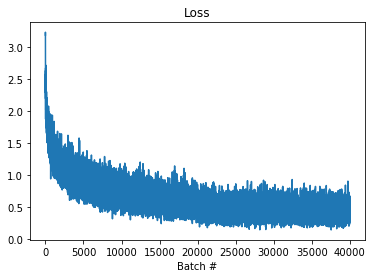

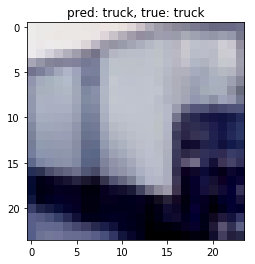

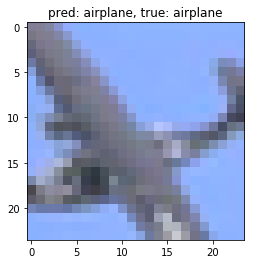

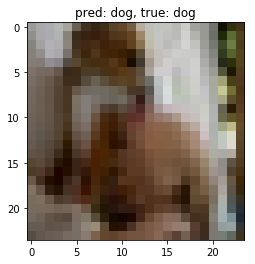

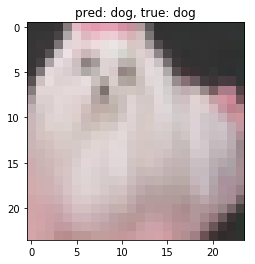

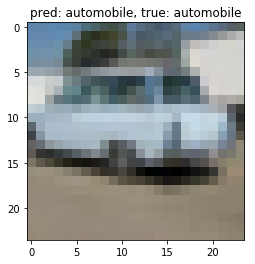

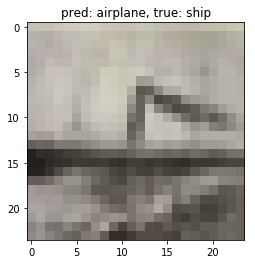

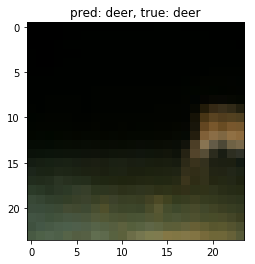

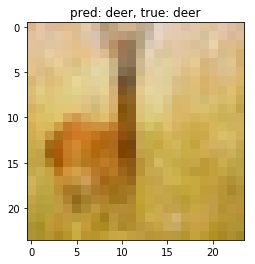

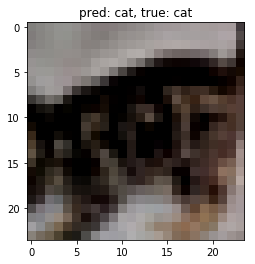

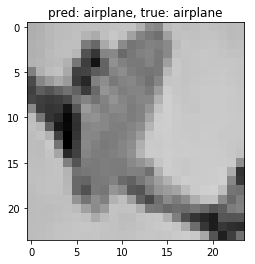

In [9]:
import visualizations
import numpy.random as nprand

visualizations.plot_learning_curve(losses)

sample_data, sample_labels = cifar_10.test.next_batch(10)
y_pred = sess.run(y, feed_dict={x: sample_data, y_true: sample_labels, keep_prob:1})

visualizations.visualize_cifar_10(sample_data, y_pred, sample_labels)

In [11]:
sess.close()